# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use('fivethirtyeight')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller, kpss

# Load Dataset

In [2]:
df = pd.read_csv(r'C:\AIML\Data\Forecast - MKBF Overall.csv')

In [3]:
print('-'*60)
print('*** Head of the dataframe ***')
print('-'*60)
print(df.head())
print('-'*60)
print('*** Tail of the dataframe ***')
print('-'*60)
print(df.tail())

------------------------------------------------------------
*** Head of the dataframe ***
------------------------------------------------------------
         Date       MKBF
0  2022-01-01  162857.36
1  2022-02-01  166095.85
2  2022-03-01  170312.92
3  2022-04-01  168292.95
4  2022-05-01  160212.42
------------------------------------------------------------
*** Tail of the dataframe ***
------------------------------------------------------------
          Date       MKBF
36  2025-01-01  372021.29
37  2025-02-01  365659.91
38  2025-03-01  372818.80
39  2025-04-01  417263.30
40  2025-05-01  495256.74


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    41 non-null     object 
 1   MKBF    41 non-null     float64
dtypes: float64(1), object(1)
memory usage: 788.0+ bytes


# Data Cleaning

In [5]:
df['Date'] = pd.to_datetime(df['Date'])  # Change date to datetime
df = df[df['Date'].dt.year >= 2023] # Filter MKBF for 2023 onwards since the data started to stable starting 2023
df.info()

# Check for null values 
# Check for duplicate values

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 12 to 40
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    29 non-null     datetime64[ns]
 1   MKBF    29 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 696.0 bytes


# Exploratory Data Analysis (EDA)

### 1. Time Series Plot

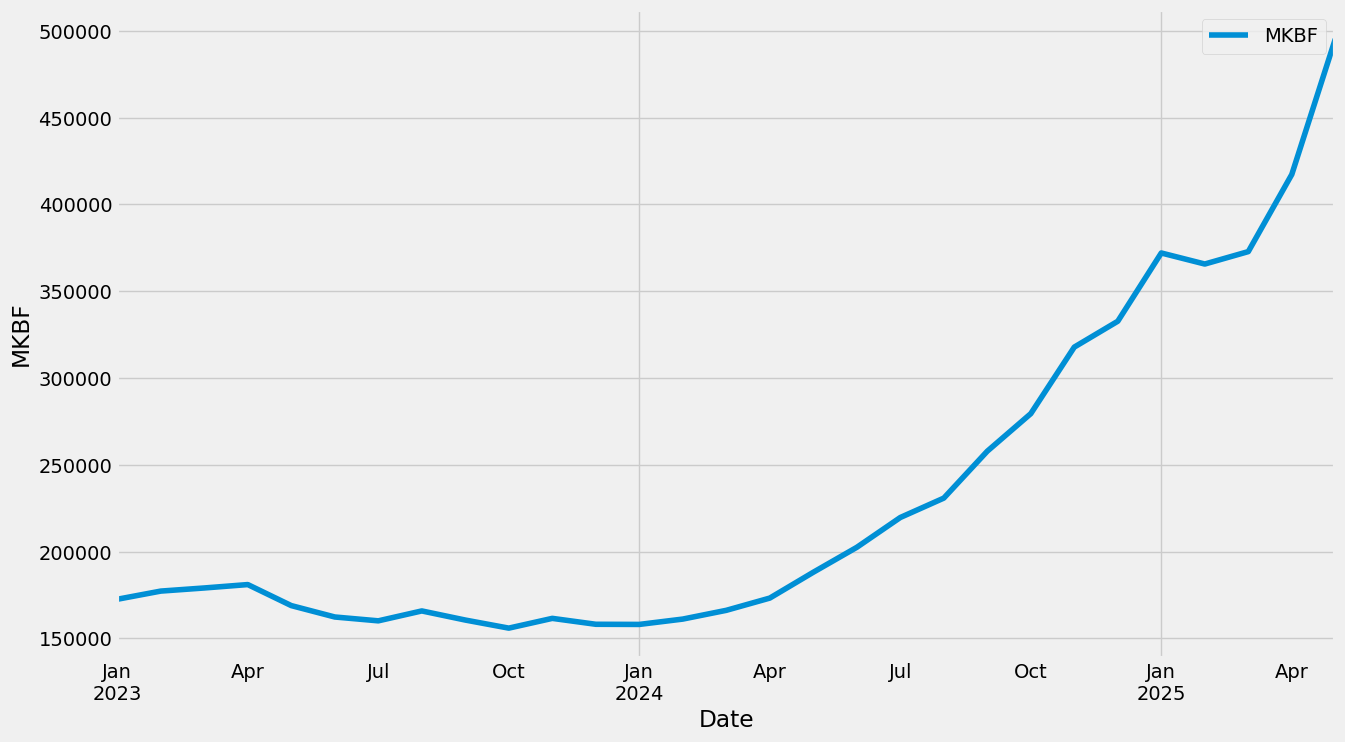

In [6]:
ax = df.set_index('Date').plot(figsize=(14, 8))
ax.set_ylabel('MKBF')
ax.set_xlabel('Date')

plt.show()

1) Trend - There is a clear upward trend in MKBF starting around October 2023, continuing into late 2024.
2) Seasonality - There is no strong or clear seasonality visible.
4) Fluctuations - From Jan–Sep 2023, the MKBF was mostly flat or slightly declining.
A sharp increase occurs from Oct 2023 onward, possibly due to improvements in maintenance, fewer failures, or better systems.
There's a drop in early 2025, but it's too early to confirm if this is a seasonal dip or an anomaly.

## 1. Seasonal Plot (Day/Week/Month/Quarter)

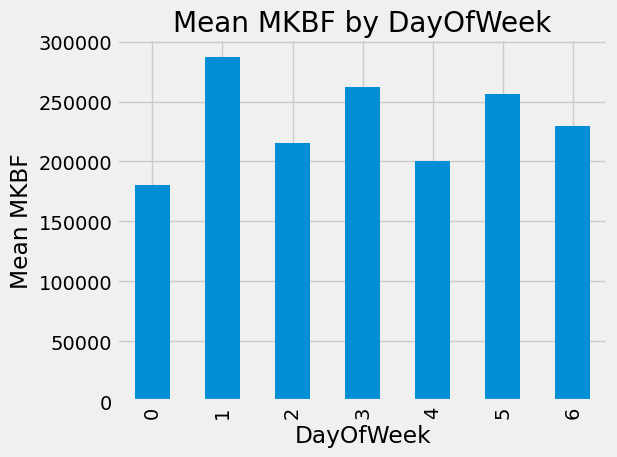

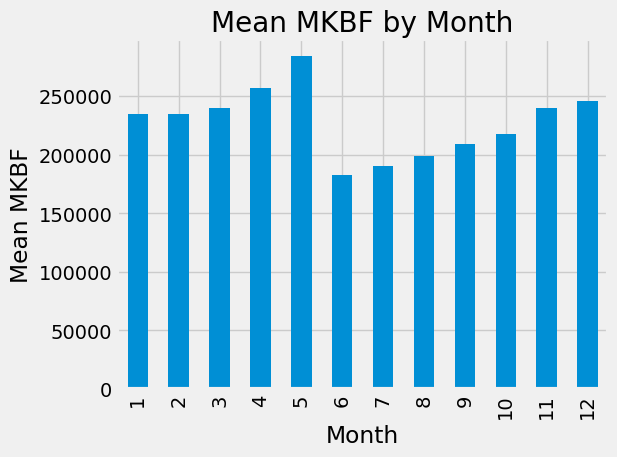

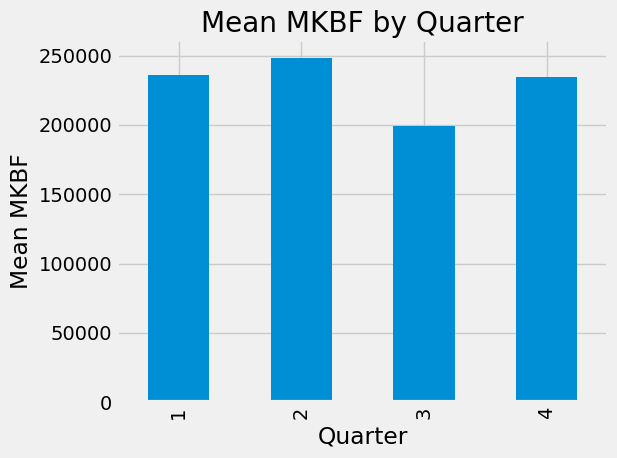

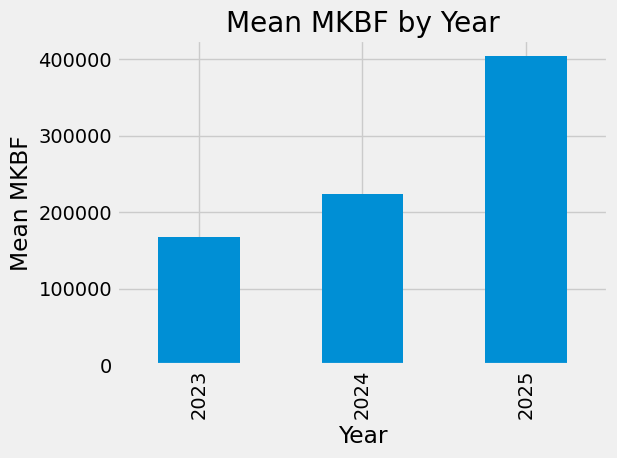

In [7]:
# Create a copy of the original DataFrame
df_copy = df.copy()

# Create time-based columns only in the copy
df_copy['DayOfWeek'] = df_copy['Date'].dt.dayofweek
df_copy['Month'] = df_copy['Date'].dt.month
df_copy['Quarter'] = df_copy['Date'].dt.quarter
df_copy['Year'] = df_copy['Date'].dt.year

# List of categorical time columns
cat_cols = ['DayOfWeek', 'Month', 'Quarter', 'Year']

# Loop and plot
for col in cat_cols:
    df_copy.groupby(col)['MKBF'].mean().plot(kind='bar')
    plt.title(f'Mean MKBF by {col}')
    plt.ylabel('Mean MKBF')
    plt.xlabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

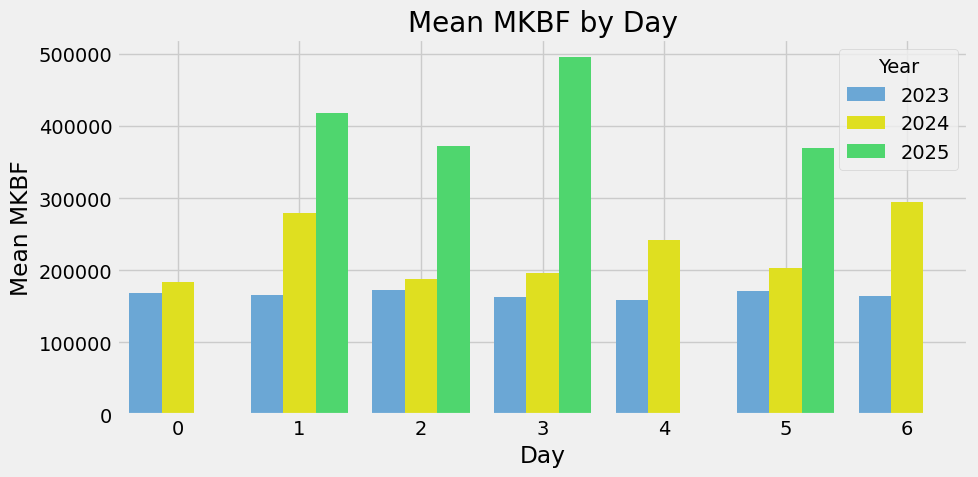

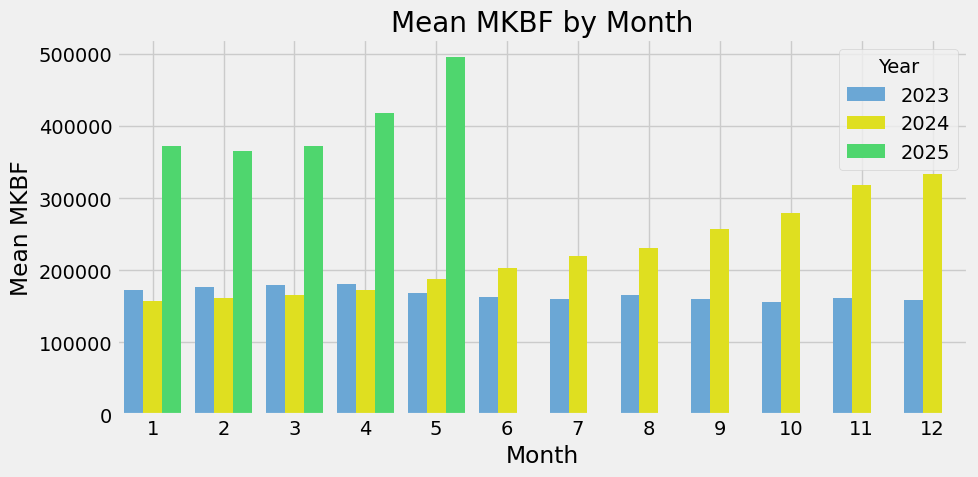

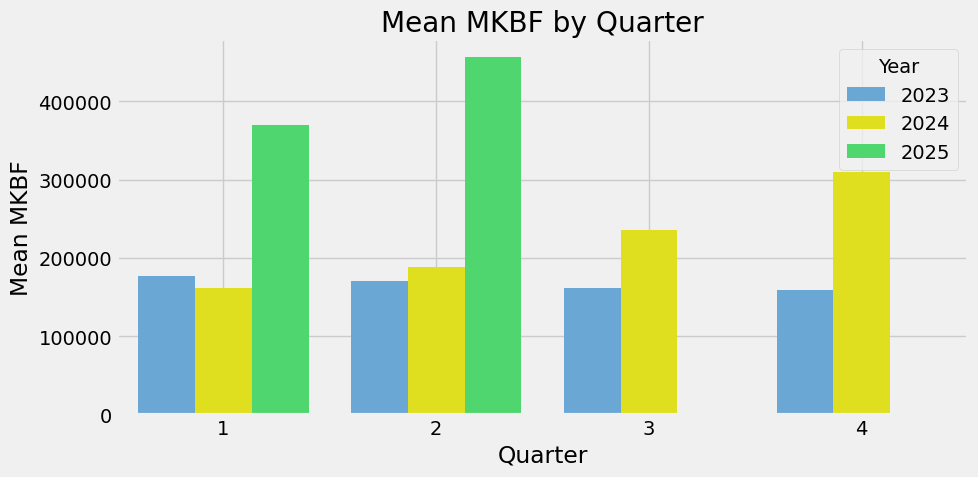

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Copy to keep original data intact
df_copy = df.copy()

# Ensure datetime format
df_copy['Date'] = pd.to_datetime(df_copy['Date'])

# Create time-based columns
df_copy['Day'] = df_copy['Date'].dt.dayofweek
df_copy['Month'] = df_copy['Date'].dt.month
df_copy['Quarter'] = df_copy['Date'].dt.quarter
df_copy['Year'] = df_copy['Date'].dt.year

# List of categorical time columns
cat_cols = ['Day', 'Month', 'Quarter']

# Define your desired color palette
custom_palette = {
    df_copy['Year'].unique()[0]: '#5aa9e6',
    df_copy['Year'].unique()[1]: 'yellow',
    df_copy['Year'].unique()[2]: '#39ec62'
}

# Plot each category with year breakdown
for col in cat_cols:
    grouped = df_copy.groupby(['Year', col])['MKBF'].mean().reset_index()

    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=col, 
        y='MKBF', 
        hue='Year', 
        data=grouped,
        palette=custom_palette
    )
    plt.title(f'Mean MKBF by {col}')
    plt.ylabel('Mean MKBF')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

1. Mean MKBF by Day of Week- Saturday (5) and Sunday (6) have higher MKBF, while weekdays like Tuesday (1) and Thursday (3) are slightly lower.
Interpretation:
Likely fewer train services or failures on weekends, leading to better MKBF (less distance/fewer failures).

2. Mean MKBF by Month - MKBF is lowest from May to August, and highest in January and December.

3. Mean MKBF by Quarter
Q1 (Jan–Mar) and Q4 (Oct–Dec) have the highest MKBF.
Q2 (Apr–Jun) has the lowest.

4. Mean MKBF by Year
Clear upward trend from 2023 to 2025.
MKBF almost doubles from 2023 to 2025.
Interpretation:
This indicates continuous improvement but because of data in 2025 only have till Jan.

## 2. Seasonal Decomposition

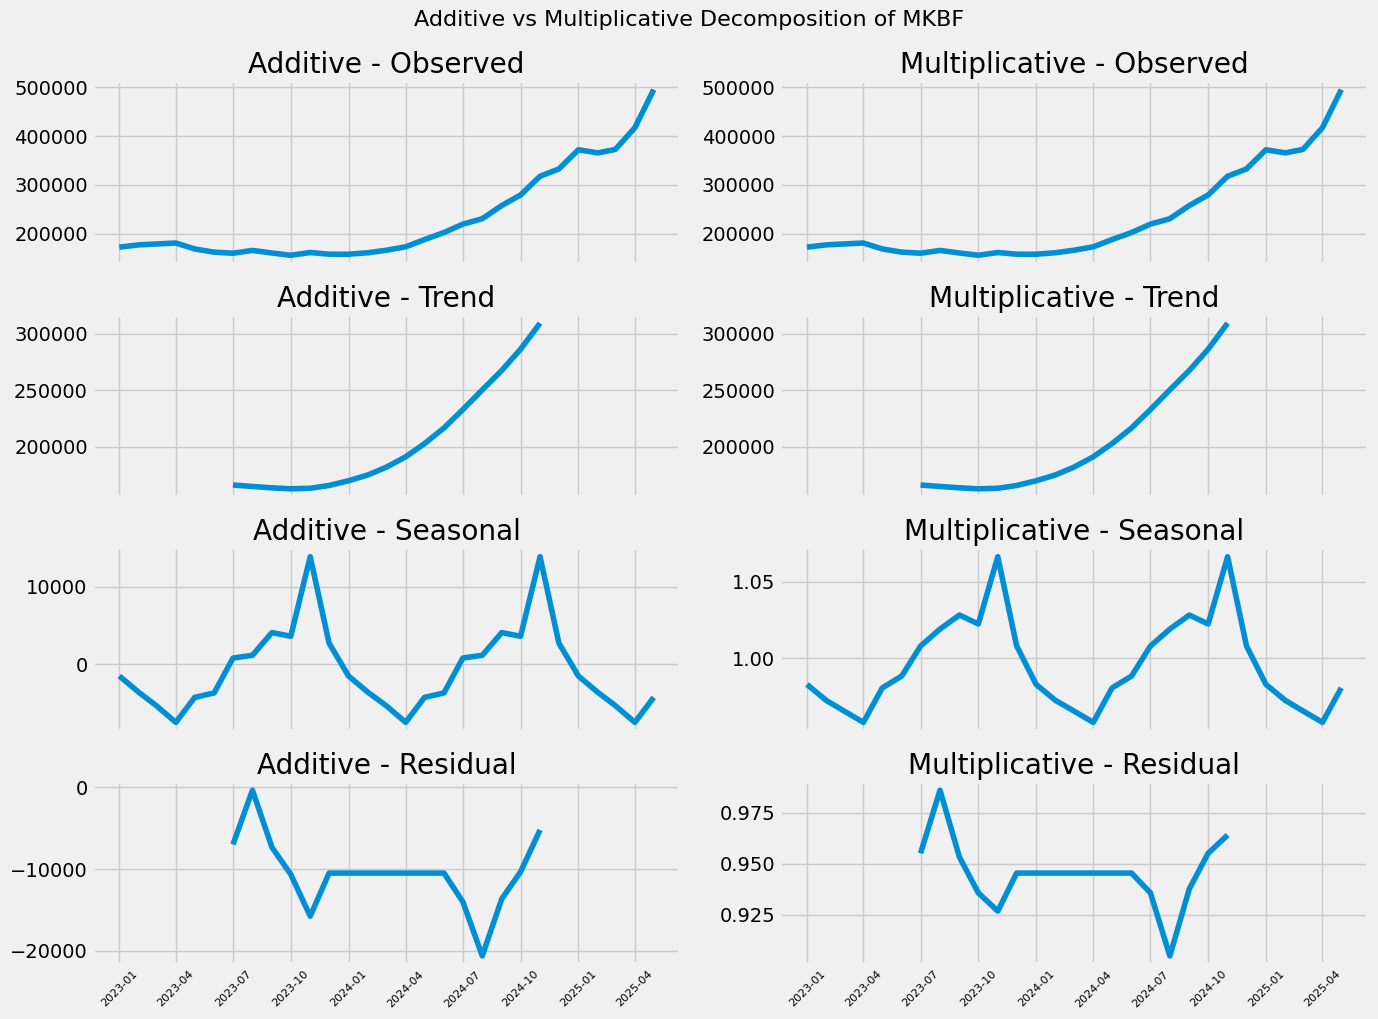

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Set index
ts = df.set_index('Date')['MKBF']

# Decompose both additive and multiplicative
decomp_add = seasonal_decompose(ts, model='additive', period=12)
decomp_mul = seasonal_decompose(ts, model='multiplicative', period=12)

# Plot both decompositions side by side
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Additive decomposition plots
axes[0, 0].plot(decomp_add.observed)
axes[0, 0].set_title('Additive - Observed')
axes[1, 0].plot(decomp_add.trend)
axes[1, 0].set_title('Additive - Trend')
axes[2, 0].plot(decomp_add.seasonal)
axes[2, 0].set_title('Additive - Seasonal')
axes[3, 0].plot(decomp_add.resid)
axes[3, 0].set_title('Additive - Residual')

# Multiplicative decomposition plots
axes[0, 1].plot(decomp_mul.observed)
axes[0, 1].set_title('Multiplicative - Observed')
axes[1, 1].plot(decomp_mul.trend)
axes[1, 1].set_title('Multiplicative - Trend')
axes[2, 1].plot(decomp_mul.seasonal)
axes[2, 1].set_title('Multiplicative - Seasonal')
axes[3, 1].plot(decomp_mul.resid)
axes[3, 1].set_title('Multiplicative - Residual')

# Make x-axis date labels smaller and rotated
for ax_row in axes:
    for ax in ax_row:
        ax.tick_params(axis='x', labelrotation=45, labelsize=8)

plt.tight_layout()
plt.suptitle('Additive vs Multiplicative Decomposition of MKBF', fontsize=16, y=1.02)
plt.show()

In [10]:
decomp_add.trend.head(12)

Date
2023-01-01              NaN
2023-02-01              NaN
2023-03-01              NaN
2023-04-01              NaN
2023-05-01              NaN
2023-06-01              NaN
2023-07-01    166349.854583
2023-08-01    165074.250417
2023-09-01    163866.071667
2023-10-01    163005.210000
2023-11-01    163481.225833
2023-12-01    165953.717917
Name: trend, dtype: float64

## 3. ACF & PACF Plot

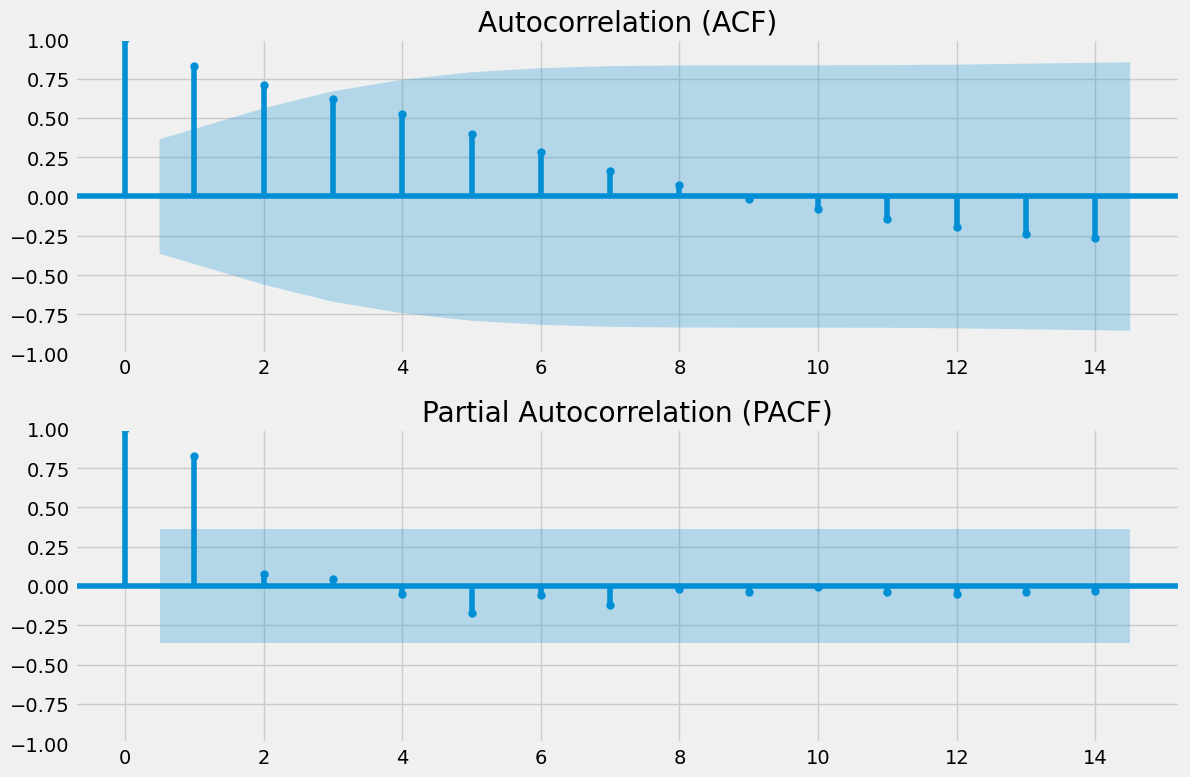

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

ts = df['MKBF']

# Automatically determine max allowable lags (half of data length)
max_lags = len(ts) // 2
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF
plot_acf(ts, ax=axes[0], lags=max_lags)
axes[0].set_title('Autocorrelation (ACF)')

# PACF
plot_pacf(ts, ax=axes[1], lags=max_lags, method='ywm')
axes[1].set_title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

ACF (Autocorrelation Function) Analysis:
High correlation at Lag 1-2 (Correlation > 0.75)

PACF (Partial Autocorrelation Function) Analysis:
High correlation at Lag 1.

## 5. Stationarity Check

In [12]:
def test_stationarity(series):
    '''Applies ADF and KPSS tests for a single time series.'''
    adf_test = adfuller(series, autolag='AIC')
    kpss_test = kpss(series, nlags='auto')

    result = pd.DataFrame({
        'Test': ['ADF', 'KPSS'],
        'Test Statistic': [adf_test[0], kpss_test[0]],
        'p-value': [adf_test[1], kpss_test[1]]
    })

    return result

# Usage
test_stationarity(df['MKBF'])

,Test,Test Statistic,p-value
0,ADF,4.703643,1.000000
1,KPSS,0.673933,0.015915


Augmented Dickey-Fuller Test (ADF)
Purpose: Tests for the presence of a unit root, i.e., whether the series is non-stationary.
Null Hypothesis (H₀): The series has a unit root → it's non-stationary.
If p-value < 0.05 → reject H₀ → likely stationary.
If p-value ≥ 0.05 → fail to reject H₀ → likely non-stationary.

KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin)
Purpose: Tests for Conc stationarity around a trend or mean.
Null Hypothesis (H₀): The series is stationary.
If p-value < 0.05 → reject H₀ → likely non-stationary.
If p-value ≥ 0.05 → fail to reject H₀ → likely stationary.

##### Conclusion : Likely Non Stationary

# Build Model

# 1) Prophet

In [13]:
# Prophet requires column names to be 'ds' and 'y' 
df_prophet = df.rename(columns={'Date': 'ds', 'MKBF': 'y'})
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 12 to 40
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      29 non-null     datetime64[ns]
 1   y       29 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 696.0 bytes


In [14]:
df_prophet.head()

,ds,y
12,2023-01-01,172568.96
13,2023-02-01,177274.22
14,2023-03-01,179071.05
15,2023-04-01,181029.28
16,2023-05-01,168913.33


# Train-Test Split

In [64]:
cutoff_date = '2024-08-31'
train_prophet = df_prophet[df_prophet['ds'] <= cutoff_date].copy()
test_prophet = df_prophet[df_prophet['ds'] > cutoff_date].copy()

In [65]:
print(train_prophet.shape)
print(test_prophet.shape)

(20, 2)
(9, 2)


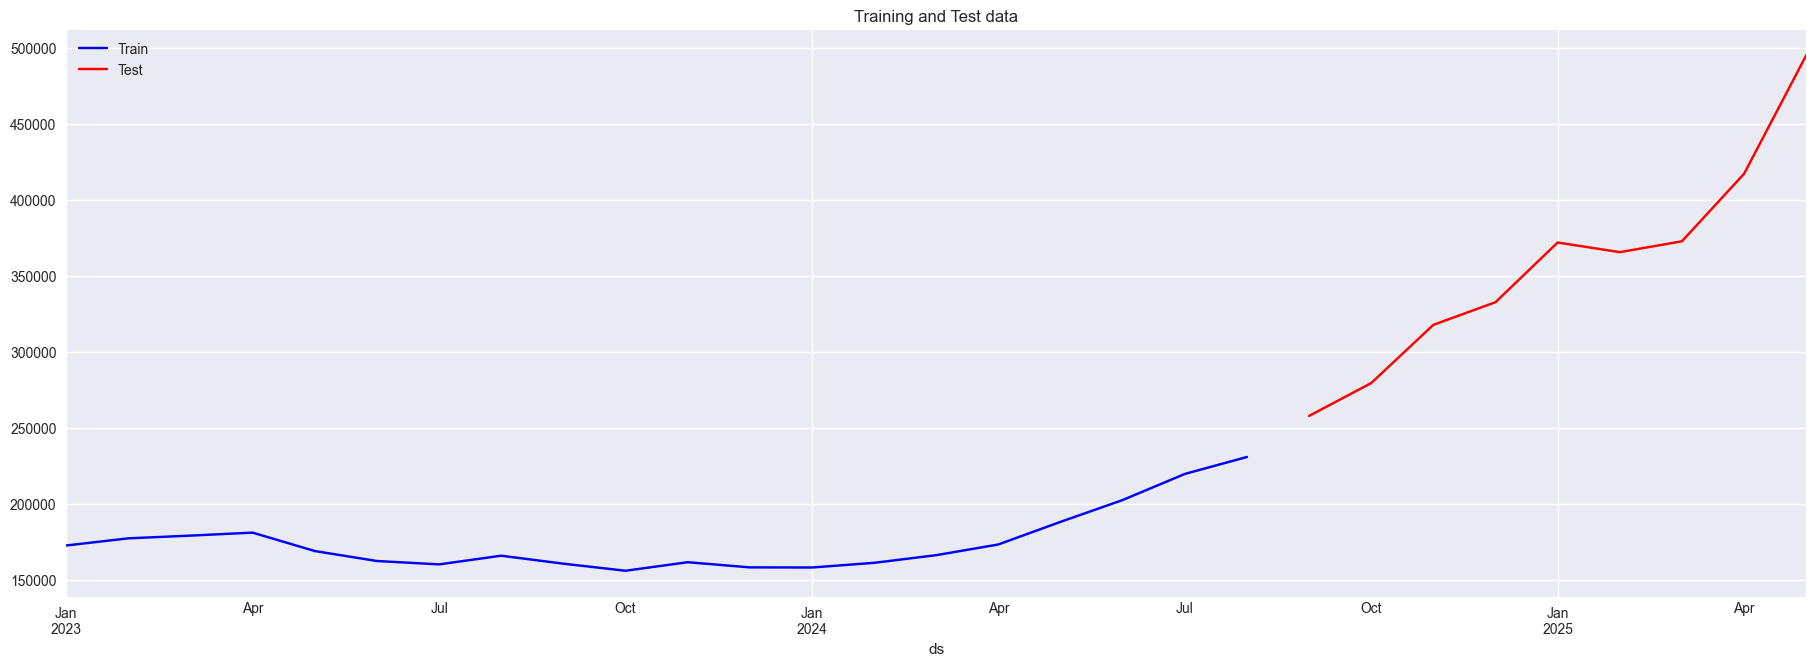

In [66]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(20,7))
train_prophet.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
test_prophet.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Training and Test data')
plt.show()

# Model Training

In [67]:
model = Prophet()
model.fit(train_prophet)

10:36:59 - cmdstanpy - INFO - Chain [1] start processing
10:36:59 - cmdstanpy - INFO - Chain [1] done processing


# Forecasting

In [68]:
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
12,2024-01-01,179493.771422,159117.191573,202619.196957
13,2024-02-01,181278.388705,157472.526144,204800.116520
14,2024-03-01,182948.651898,160609.666835,205590.009529
15,2024-04-01,184736.728281,161928.908568,208264.305845
16,2024-05-01,186467.124790,165592.005722,208362.166180
17,2024-06-01,188255.201183,165334.011550,209410.996196
18,2024-07-01,189985.597692,168711.027337,212800.466436
19,2024-08-01,191773.674085,169278.754137,213776.317448
20,2024-09-01,193561.750478,171828.965395,216667.459319
21,2024-10-01,195292.146987,172170.867363,217487.510211


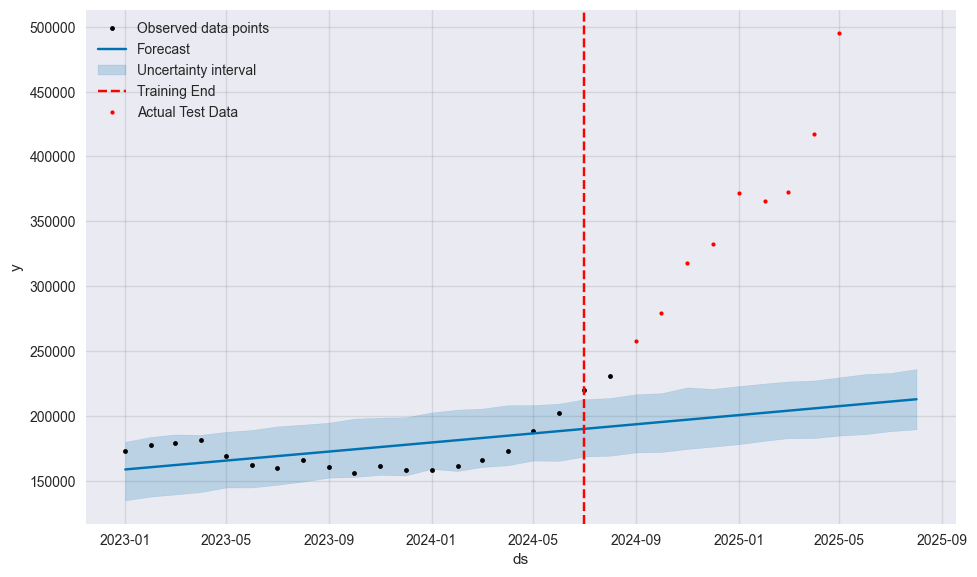

In [69]:
# plot the time series 
forecast_plot = model.plot(forecast)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast['ds'].iloc[-14]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot actual test data for the period after the red line
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])
plt.plot(test_prophet['ds'], test_prophet['y'],'ro', markersize=3, label='Actual Test Data')

# show the legend to distinguish between the lines
plt.legend()

## Actual vs Prediction Comparison

In [70]:
X_tst_forecast = model.predict(test_prophet)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
0,2024-09-01,193561.750478,172010.897866,215810.820744
1,2024-10-01,195292.146987,171611.079172,217052.183511
2,2024-11-01,197080.223380,175005.542717,220186.866303
3,2024-12-01,198810.619889,175483.608013,222647.809357
4,2025-01-01,200598.696282,177732.224527,222217.426215
5,2025-02-01,202386.772675,181067.458049,225827.730614
6,2025-03-01,204001.809417,180414.733440,227931.428583
7,2025-04-01,205789.885810,182672.325844,229700.490227
8,2025-05-01,207520.282319,186149.414244,230646.947780


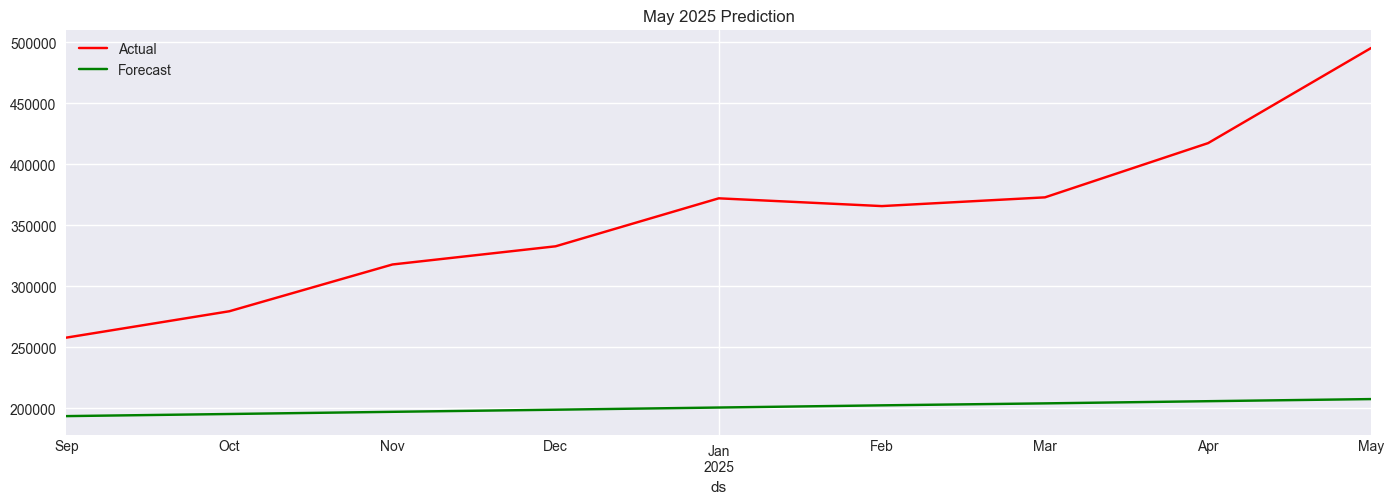

In [71]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test_prophet.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('May 2025 Prediction')
plt.show()

We can see from the above plot, that there is huge gap in prediction. So we need to optimize the model by adding other parameters.

In [72]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

mape = mean_absolute_percentage_error(test_prophet['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

rmse = np.sqrt(mean_squared_error(test_prophet['y'], X_tst_forecast['yhat']))
print("RMSE:", round(rmse, 4))

MAPE 0.4201
RMSE: 168583.9138


Add holiday to the model

In [73]:
import holidays

In [74]:
import holidays
import pandas as pd

# Define years of interest
years = [2023, 2024, 2025]

# Get holidays for Kuala Lumpur and Selangor
kl_holidays = holidays.country_holidays('MY', subdiv='KUL', years=years)
selangor_holidays = holidays.country_holidays('MY', subdiv='SGR', years=years)

# Convert each to a DataFrame
df_kl = pd.DataFrame([
    {'ds': date, 'holiday': 'Kuala_Lumpur_Holiday'}
    for date, name in sorted(kl_holidays.items())
])

df_sgr = pd.DataFrame([
    {'ds': date, 'holiday': 'Selangor_Holiday'}
    for date, name in sorted(selangor_holidays.items())
])

# Combine and remove duplicates (if same date exists)
holiday_df = pd.concat([df_kl, df_sgr]).drop_duplicates(subset='ds').reset_index(drop=True)

# Ensure datetime format
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

# Preview
print(holiday_df.head())

          ds               holiday
0 2023-01-01  Kuala_Lumpur_Holiday
1 2023-01-02  Kuala_Lumpur_Holiday
2 2023-01-22  Kuala_Lumpur_Holiday
3 2023-01-23  Kuala_Lumpur_Holiday
4 2023-01-24  Kuala_Lumpur_Holiday


In [75]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train_prophet)

10:37:08 - cmdstanpy - INFO - Chain [1] start processing
10:37:08 - cmdstanpy - INFO - Chain [1] done processing


In [76]:
future = model_with_holidays.make_future_dataframe(periods=12, freq='MS')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
25,2025-02-01,200879.494341,177134.418437,222282.705256
26,2025-03-01,203912.764130,182190.004948,226429.279046
27,2025-04-01,204217.450850,181171.825196,227556.852395
28,2025-05-01,205914.716872,184331.814952,229100.844264
29,2025-06-01,209117.713263,187085.205089,232413.005817
30,2025-07-01,210814.979285,188354.428518,231593.535674
31,2025-08-01,212568.820840,191069.145692,236021.993869


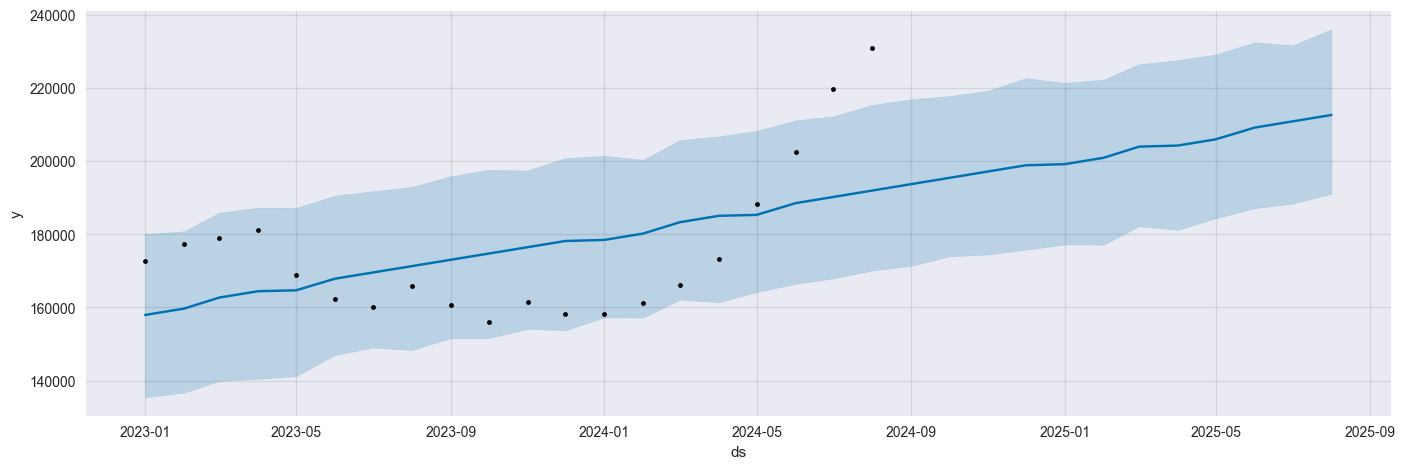

In [77]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

In [78]:
X_tst_forecast_holiday = model_with_holidays.predict(test_prophet)
X_tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
0,2024-09-01,193672.592466,171632.914207,215689.891966
1,2024-10-01,195369.858487,173338.901529,217216.262828
2,2024-11-01,197123.700043,173161.530345,218716.870561
3,2024-12-01,198820.966065,177054.430397,221148.494456
4,2025-01-01,199125.652785,175887.220968,220013.540612
5,2025-02-01,200879.494341,177983.644504,222045.244257
6,2025-03-01,203912.764130,180904.888307,224928.329394
7,2025-04-01,204217.450850,182286.735707,226694.795822
8,2025-05-01,205914.716872,184485.054973,228852.689564


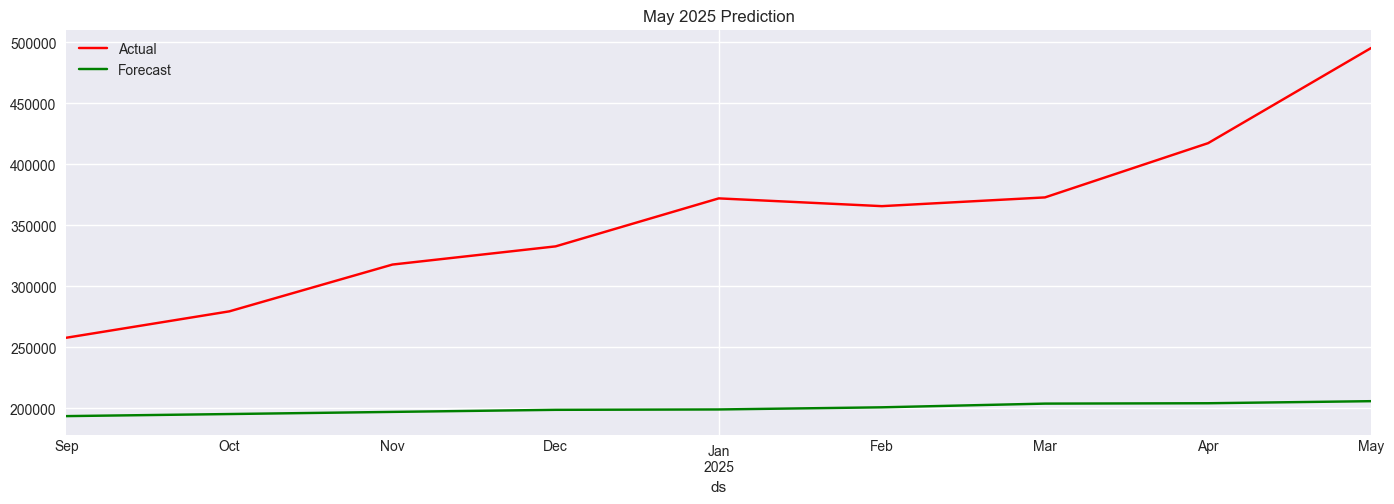

In [79]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test_prophet.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('May 2025 Prediction')
plt.show()

In [80]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Calculate MAPE (as you already have)
mape = mean_absolute_percentage_error(test_prophet['y'], X_tst_forecast_holiday['yhat'])
print("MAPE:", round(mape, 4))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_prophet['y'], X_tst_forecast_holiday['yhat']))
print("RMSE:", round(rmse, 4))

MAPE: 0.4217
RMSE: 169433.71


MAPE after adding holidays is lower than without holidays.

Along with holidays, there are many other hyperparameters which helps in optimizing the prophet model.

1) Holidays
2) Changepoints: (n_changepoints,changepoint_prior_scale)
3) seasonality_mode
4) holiday_prior_scale
5) Seasonalities with fourier_order
We have added holidays to our model and saw its effect.

n_changepoints is the number of change happen in the data. Prophet model detects them by its own. By default, its value is 25, which are uniformly placed in the first 80% of the time series. Changing n_changepoints can add value to the model.

changepoint_prior_scale to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If you make it high it will be more flexible, but you can end up overfitting. By default, this parameter is set to 0.05

seasonality_mode There are 2 types model seasonality mode. Additive & multiplicaticative. By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the model.

holiday_prior_scale just like changepoint_prior_scale, holiday_prior_scale is used to smoothning the effect of holidays. By default its value is 10, which provides very little regularization. Reducing this parameter dampens holiday effects

Seasonalities with fourier_order Prophet model, by default finds the seasonalities and adds the default parameters of the seasonality. We can modify the seasonalities effect by adding custom seasonalities as add_seasonality in the model with different fourier order.Yy default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.

Now, we will do the hyperparameters tuning using parametergrid. parametergrid will create all the possible parameters combination and will test the model prediction using every combination.

# HyperParameter Tuning using ParameterGrid

In [81]:
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import pandas as pd
import traceback

# Define parameter grid with log-scaled priors
params_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

grid = ParameterGrid(params_grid)
print(f'Total Possible Models: {len(grid)}')

Total Possible Models: 128


# Prophet Model Tuning

In [82]:
model_parameters = pd.DataFrame(columns=['RMSE', 'Parameters'])

for p in grid:
    try:
        print(f"\nTesting parameters: {p}")
        
        model = Prophet(
            changepoint_prior_scale=p['changepoint_prior_scale'],
            seasonality_prior_scale=p['seasonality_prior_scale'],
            seasonality_mode=p['seasonality_mode'],
            holidays_prior_scale=p['holidays_prior_scale'],
            yearly_seasonality=True,
            holidays=holiday_df,
            interval_width=0.95
        )

        model.fit(train_prophet)

        # Forecast for test period
        future_df = test_prophet[['ds']].copy()
        forecast = model.predict(future_df)

        # Align with actual values
        actual = test_prophet.set_index('ds').loc[forecast['ds'], 'y'].values
        predicted = forecast['yhat'].values

        mape = mean_absolute_percentage_error(actual, abs(predicted))
        print(f"RMSE: {rmse:.4f}")

        model_parameters = pd.concat([
            model_parameters,
            pd.DataFrame([{'RMSE': mape, 'Parameters': p}])
        ], ignore_index=True)

    except Exception as e:
        print(f"❌ Error with parameters: {p}")
        traceback.print_exc()

# Display best result
if not model_parameters.empty:
    best = model_parameters.sort_values(by='RMSE').iloc[0]
    print("\n✅ Best parameter set:")
    print(best)
else:
    print("\n⚠️ No successful model runs.")

10:37:23 - cmdstanpy - INFO - Chain [1] start processing
10:37:23 - cmdstanpy - INFO - Chain [1] done processing



Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


C:\Users\athirah.zahidin\AppData\Local\Temp\ipykernel_12568\1818882711.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_parameters = pd.concat([
10:37:23 - cmdstanpy - INFO - Chain [1] start processing
10:37:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:37:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:37:23 - cmdstanpy - INFO - Chain [1] done processing
10:37:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:37:24 - cmdstanpy - INFO - Chain [1] done processing
10:37:24 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:37:24 - cmdstanpy - INFO - Chain [1] done processing
10:37:25 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:37:25 - cmdstanpy - INFO - Chain [1] done processing
10:37:25 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:37:25 - cmdstanpy - INFO - Chain [1] done processing
10:37:25 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:37:25 - cmdstanpy - INFO - Chain [1] done processing
10:37:26 - cmdstanpy - INFO - Chain [1] start processing
10:37:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:37:26 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:37:26 - cmdstanpy - INFO - Chain [1] done processing
10:37:26 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:37:26 - cmdstanpy - INFO - Chain [1] done processing
10:37:26 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:37:27 - cmdstanpy - INFO - Chain [1] done processing
10:37:27 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:37:27 - cmdstanpy - INFO - Chain [1] done processing
10:37:27 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:37:28 - cmdstanpy - INFO - Chain [1] done processing
10:37:28 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:37:28 - cmdstanpy - INFO - Chain [1] done processing
10:37:28 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:37:28 - cmdstanpy - INFO - Chain [1] done processing
10:37:28 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:37:29 - cmdstanpy - INFO - Chain [1] done processing
10:37:29 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:37:29 - cmdstanpy - INFO - Chain [1] done processing
10:37:29 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:37:29 - cmdstanpy - INFO - Chain [1] done processing
10:37:29 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:37:31 - cmdstanpy - INFO - Chain [1] done processing
10:37:31 - cmdstanpy - INFO - Chain [1] start processing
10:37:31 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:37:31 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:37:31 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:37:32 - cmdstanpy - INFO - Chain [1] start processing
10:37:32 - cmdstanpy - INFO - Chain [1] done processing
10:37:32 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:37:32 - cmdstanpy - INFO - Chain [1] done processing
10:37:32 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:37:33 - cmdstanpy - INFO - Chain [1] done processing
10:37:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:37:33 - cmdstanpy - INFO - Chain [1] done processing
10:37:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:37:33 - cmdstanpy - INFO - Chain [1] done processing
10:37:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:37:34 - cmdstanpy - INFO - Chain [1] done processing
10:37:34 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:37:34 - cmdstanpy - INFO - Chain [1] done processing
10:37:34 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:37:34 - cmdstanpy - INFO - Chain [1] done processing
10:37:34 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:37:35 - cmdstanpy - INFO - Chain [1] done processing
10:37:35 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:37:35 - cmdstanpy - INFO - Chain [1] done processing
10:37:35 - cmdstanpy - INFO - Chain [1] start processing
10:37:36 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:37:36 - cmdstanpy - INFO - Chain [1] start processing
10:37:36 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:37:36 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:37:36 - cmdstanpy - INFO - Chain [1] done processing
10:37:36 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:37:41 - cmdstanpy - INFO - Chain [1] done processing
10:37:41 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:37:41 - cmdstanpy - INFO - Chain [1] done processing
10:37:41 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:37:41 - cmdstanpy - INFO - Chain [1] done processing
10:37:41 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:37:42 - cmdstanpy - INFO - Chain [1] done processing
10:37:42 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:37:43 - cmdstanpy - INFO - Chain [1] done processing
10:37:43 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:37:43 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:37:44 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:37:44 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:37:47 - cmdstanpy - INFO - Chain [1] done processing
10:37:47 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:37:47 - cmdstanpy - INFO - Chain [1] done processing
10:37:47 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:37:47 - cmdstanpy - INFO - Chain [1] done processing
10:37:48 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:37:48 - cmdstanpy - INFO - Chain [1] done processing
10:37:48 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:37:49 - cmdstanpy - INFO - Chain [1] done processing
10:37:49 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:37:49 - cmdstanpy - INFO - Chain [1] done processing
10:37:49 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:37:49 - cmdstanpy - INFO - Chain [1] done processing
10:37:49 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:37:50 - cmdstanpy - INFO - Chain [1] done processing
10:37:50 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:37:53 - cmdstanpy - INFO - Chain [1] done processing
10:37:53 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:37:53 - cmdstanpy - INFO - Chain [1] done processing
10:37:53 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:37:53 - cmdstanpy - INFO - Chain [1] done processing
10:37:53 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:37:54 - cmdstanpy - INFO - Chain [1] done processing
10:37:54 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:37:56 - cmdstanpy - INFO - Chain [1] done processing
10:37:56 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:37:56 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:37:56 - cmdstanpy - INFO - Chain [1] start processing
10:37:56 - cmdstanpy - INFO - Chain [1] done processing
10:37:56 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:37:57 - cmdstanpy - INFO - Chain [1] done processing
10:37:58 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:38:00 - cmdstanpy - INFO - Chain [1] done processing
10:38:00 - cmdstanpy - INFO - Chain [1] start processing
10:38:00 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:38:01 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:38:01 - cmdstanpy - INFO - Chain [1] done processing
10:38:01 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:38:01 - cmdstanpy - INFO - Chain [1] done processing
10:38:02 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:38:02 - cmdstanpy - INFO - Chain [1] done processing
10:38:02 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:38:13 - cmdstanpy - INFO - Chain [1] done processing
10:38:13 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:38:24 - cmdstanpy - INFO - Chain [1] done processing
10:38:24 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:38:34 - cmdstanpy - INFO - Chain [1] done processing
10:38:34 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:38:43 - cmdstanpy - INFO - Chain [1] done processing
10:38:43 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:38:53 - cmdstanpy - INFO - Chain [1] done processing
10:38:53 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:39:02 - cmdstanpy - INFO - Chain [1] done processing
10:39:02 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:39:12 - cmdstanpy - INFO - Chain [1] done processing
10:39:12 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:39:22 - cmdstanpy - INFO - Chain [1] done processing
10:39:22 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:39:33 - cmdstanpy - INFO - Chain [1] done processing
10:39:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:39:44 - cmdstanpy - INFO - Chain [1] done processing
10:39:44 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:39:54 - cmdstanpy - INFO - Chain [1] done processing
10:39:54 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:40:04 - cmdstanpy - INFO - Chain [1] done processing
10:40:04 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:40:14 - cmdstanpy - INFO - Chain [1] done processing
10:40:14 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:40:24 - cmdstanpy - INFO - Chain [1] done processing
10:40:24 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:40:33 - cmdstanpy - INFO - Chain [1] done processing
10:40:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:40:43 - cmdstanpy - INFO - Chain [1] done processing
10:40:43 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:40:54 - cmdstanpy - INFO - Chain [1] done processing
10:40:54 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:41:04 - cmdstanpy - INFO - Chain [1] done processing
10:41:04 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:41:15 - cmdstanpy - INFO - Chain [1] done processing
10:41:15 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:41:25 - cmdstanpy - INFO - Chain [1] done processing
10:41:25 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:41:34 - cmdstanpy - INFO - Chain [1] done processing
10:41:34 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:41:44 - cmdstanpy - INFO - Chain [1] done processing
10:41:44 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:41:53 - cmdstanpy - INFO - Chain [1] done processing
10:41:53 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:42:03 - cmdstanpy - INFO - Chain [1] done processing
10:42:03 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:42:03 - cmdstanpy - INFO - Chain [1] done processing
10:42:03 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:42:13 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:42:23 - cmdstanpy - INFO - Chain [1] done processing
10:42:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:42:33 - cmdstanpy - INFO - Chain [1] done processing
10:42:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:42:42 - cmdstanpy - INFO - Chain [1] done processing
10:42:43 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:42:52 - cmdstanpy - INFO - Chain [1] done processing
10:42:52 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:43:02 - cmdstanpy - INFO - Chain [1] done processing
10:43:02 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:43:12 - cmdstanpy - INFO - Chain [1] done processing
10:43:12 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:43:23 - cmdstanpy - INFO - Chain [1] done processing
10:43:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:43:33 - cmdstanpy - INFO - Chain [1] done processing
10:43:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:43:43 - cmdstanpy - INFO - Chain [1] done processing
10:43:43 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:43:53 - cmdstanpy - INFO - Chain [1] done processing
10:43:53 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:44:03 - cmdstanpy - INFO - Chain [1] done processing
10:44:03 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:44:13 - cmdstanpy - INFO - Chain [1] done processing
10:44:13 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:44:23 - cmdstanpy - INFO - Chain [1] done processing
10:44:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:44:32 - cmdstanpy - INFO - Chain [1] done processing
10:44:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:44:42 - cmdstanpy - INFO - Chain [1] done processing
10:44:42 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:44:52 - cmdstanpy - INFO - Chain [1] done processing
10:44:52 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:45:02 - cmdstanpy - INFO - Chain [1] done processing
10:45:02 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:45:13 - cmdstanpy - INFO - Chain [1] done processing
10:45:13 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:45:23 - cmdstanpy - INFO - Chain [1] done processing
10:45:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:45:34 - cmdstanpy - INFO - Chain [1] done processing
10:45:35 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:45:45 - cmdstanpy - INFO - Chain [1] done processing
10:45:45 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:45:54 - cmdstanpy - INFO - Chain [1] done processing
10:45:54 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:46:04 - cmdstanpy - INFO - Chain [1] done processing
10:46:04 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:46:14 - cmdstanpy - INFO - Chain [1] done processing
10:46:14 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:46:25 - cmdstanpy - INFO - Chain [1] done processing
10:46:25 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:46:36 - cmdstanpy - INFO - Chain [1] done processing
10:46:36 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:46:46 - cmdstanpy - INFO - Chain [1] done processing
10:46:46 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:46:57 - cmdstanpy - INFO - Chain [1] done processing
10:46:57 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:47:07 - cmdstanpy - INFO - Chain [1] done processing
10:47:08 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:47:18 - cmdstanpy - INFO - Chain [1] done processing
10:47:18 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


10:47:29 - cmdstanpy - INFO - Chain [1] done processing
10:47:29 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


10:47:40 - cmdstanpy - INFO - Chain [1] done processing
10:47:40 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


10:47:51 - cmdstanpy - INFO - Chain [1] done processing
10:47:51 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


10:48:02 - cmdstanpy - INFO - Chain [1] done processing
10:48:02 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


10:48:13 - cmdstanpy - INFO - Chain [1] done processing
10:48:13 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


10:48:23 - cmdstanpy - INFO - Chain [1] done processing
10:48:23 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


10:48:33 - cmdstanpy - INFO - Chain [1] done processing
10:48:33 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 169433.7100

Testing parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


10:48:44 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 169433.7100

✅ Best parameter set:
RMSE                                                   0.037335
Parameters    {'changepoint_prior_scale': 0.5, 'holidays_pri...
Name: 101, dtype: object


In [83]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters
0,0.037335,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
1,0.088612,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
2,0.094946,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
3,0.099780,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
4,0.113058,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."


Out of total 150 models, we will select the parameters which has the least MAPE to train the final model and predict the next 2 months sales of the store.

Best Parameters on which the model has the least MAPE is:

In [84]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 0.1}

In [85]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday_df,
                      changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.01,
                      seasonality_mode = 'additive',
                      seasonality_prior_scale=0.1,)
final_model.fit(train_prophet)

10:57:02 - cmdstanpy - INFO - Chain [1] start processing
10:57:02 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
future_final = final_model.make_future_dataframe(periods=24, freq='MS')
forecast_final = final_model.predict(future_final)
forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
14,2024-03-01,166193.967820,165355.708465,1.670539e+05
15,2024-04-01,173681.832917,172867.155602,1.745381e+05
16,2024-05-01,187995.964319,187226.739835,1.888132e+05
17,2024-06-01,202983.299093,202175.421300,2.037770e+05
18,2024-07-01,217393.856229,216517.635440,2.182005e+05
19,2024-08-01,232284.765270,231479.931978,2.330914e+05
20,2024-09-01,247175.674310,243736.370824,2.511936e+05
21,2024-10-01,261586.231446,250788.474821,2.741022e+05
22,2024-11-01,276477.140486,254461.560895,2.997903e+05
23,2024-12-01,290887.697622,255801.814295,3.274450e+05


C:\Users\athirah.zahidin\AppData\Local\Temp\ipykernel_12568\1148313388.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Clean modern style


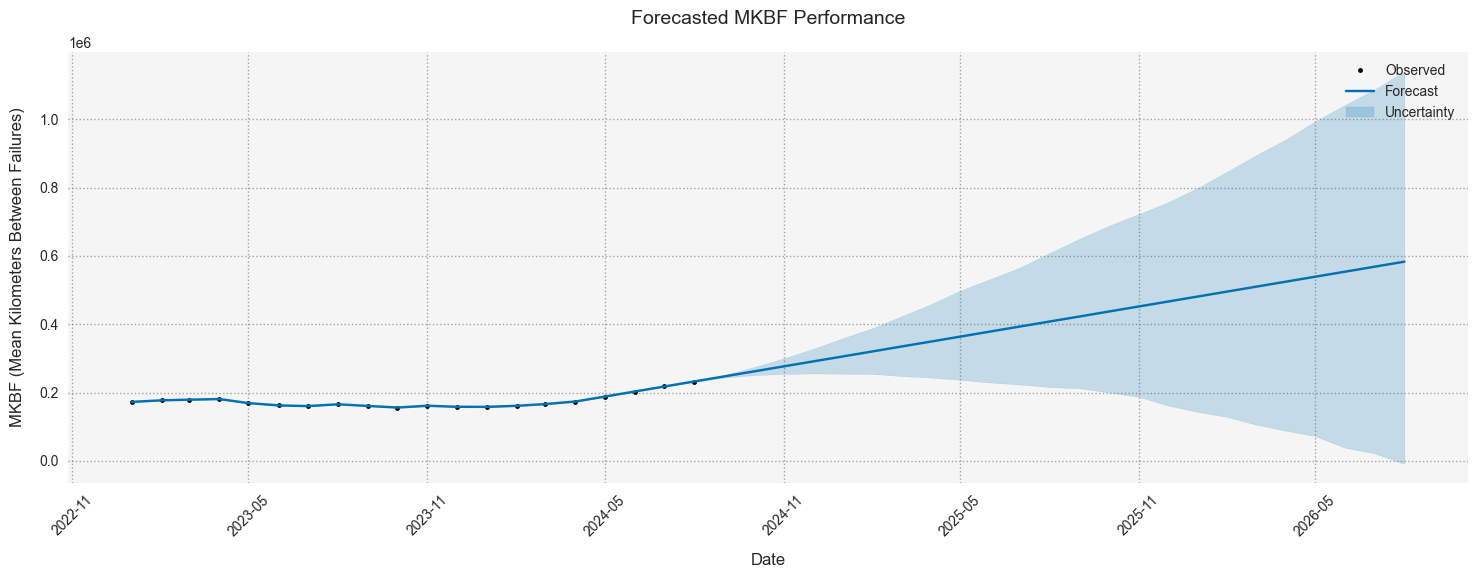

In [87]:
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt

# Set up plot with professional styling
plt.style.use('seaborn')  # Clean modern style
f, ax = plt.subplots(figsize=(15, 6))  # Slightly taller for better proportions

# Plot the Prophet forecast
fig = final_model.plot(forecast_final, ax=ax)

# Format x-axis dates
date_form = DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(date_form)
ax.tick_params(axis='x', rotation=45, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Add professional styling
plt.grid(True, linestyle=':', alpha=0.7)  # Subtler grid lines
plt.title('Forecasted MKBF Performance', fontsize=14, pad=20)  # Add padding
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('MKBF (Mean Kilometers Between Failures)', fontsize=12, labelpad=10)

# Remove spines for cleaner look
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Auto-adjust y-axis based on data
ax.set_autoscaley_on(True)

# Add light background color
ax.set_facecolor('#f5f5f5')

# Add legend if not automatically shown
if not ax.get_legend():
    ax.legend(['Observed', 'Forecast', 'Uncertainty'], 
              facecolor='white', framealpha=1)

plt.tight_layout()
plt.show()

In [88]:
final_forecast_tuned = final_model.predict(test_prophet)
final_forecast_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
0,2024-09-01,247175.674310,243740.158757,251316.501179
1,2024-10-01,261586.231446,251105.755302,275514.391831
2,2024-11-01,276477.140486,254618.353037,301266.319971
3,2024-12-01,290887.697622,256348.098592,328999.208665
4,2025-01-01,305682.180927,257259.660013,358525.917501
5,2025-02-01,320573.089968,257126.011469,391290.574044
6,2025-03-01,334119.369029,255234.096018,421598.857613
7,2025-04-01,348913.852335,253012.927422,456563.983867
8,2025-05-01,363324.409471,246788.453184,492252.239038


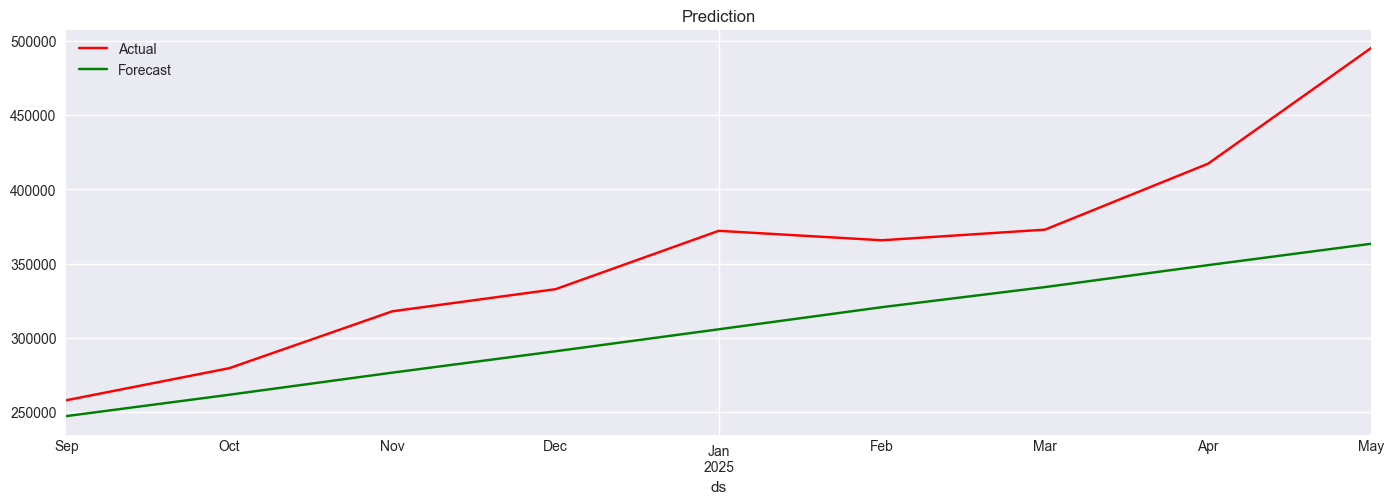

In [89]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test_prophet.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
final_forecast_tuned.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Prediction')
plt.show()

In [90]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

mape = mean_absolute_percentage_error(test_prophet['y'],final_forecast_tuned['yhat'])
print("MAPE",round(mape,4))

rmse = np.sqrt(mean_squared_error(test_prophet['y'], final_forecast_tuned['yhat']))
print("RMSE:", round(rmse, 4))

MAPE 0.133
RMSE: 61374.6323


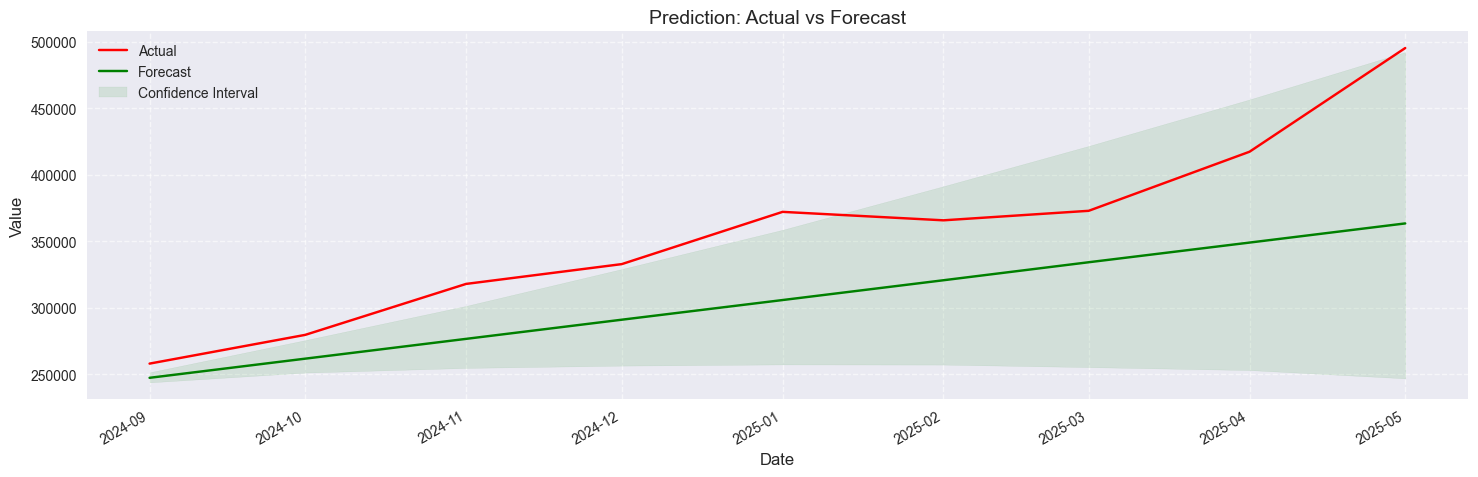

In [91]:
import matplotlib.pyplot as plt
import pandas as pd

# Set up the figure
plt.figure(figsize=(15, 5))  # Match your original dimensions

# Convert Prophet's ds to datetime if needed
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])
final_forecast_tuned['ds'] = pd.to_datetime(final_forecast_tuned['ds'])

# Plot actual values
plt.plot(test_prophet['ds'], test_prophet['y'], 
        color='red', 
        label='Actual')

# Plot forecast
plt.plot(final_forecast_tuned['ds'], final_forecast_tuned['yhat'], 
        color='green', 
        label='Forecast')

# Add confidence interval if available
if 'yhat_lower' in final_forecast_tuned.columns:
    plt.fill_between(final_forecast_tuned['ds'],
                    final_forecast_tuned['yhat_lower'],
                    final_forecast_tuned['yhat_upper'],
                    color='green', alpha=0.1,
                    label='Confidence Interval')

# Formatting
plt.title('Prediction: Actual vs Forecast', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Auto-format dates
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()